<a href="https://colab.research.google.com/github/yasirrustam06/All-colab-codes/blob/main/Gan_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Define the generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Loss function for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Loss function for generator
def generator_loss(fake_output):
    return tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Define the GAN model
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




In [ ]:
import numpy as np

In [ ]:
BUFFER_SIZE = 227
BATCH_SIZE = 15

In [ ]:
path="/content/ruppes.npy"
train_images = np.load(path)

In [ ]:
train_images.shape

(227, 28, 28, 1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
EPOCHS = 300
losses = []
accuracies = []
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)

    # Calculate metrics
    gen_loss = generator_loss(discriminator(generator(tf.random.normal([BATCH_SIZE, 100]), training=False)))
    disc_loss = discriminator_loss(discriminator(image_batch, training=False),
                                   discriminator(generator(tf.random.normal([BATCH_SIZE, 100]), training=False),
                                                 training=False))
    losses.append((gen_loss, disc_loss))
    accuracies.append(disc_loss)

In [ ]:
generator.save('rupees_Model.h5')


In [ ]:
import matplotlib.pyplot as plt

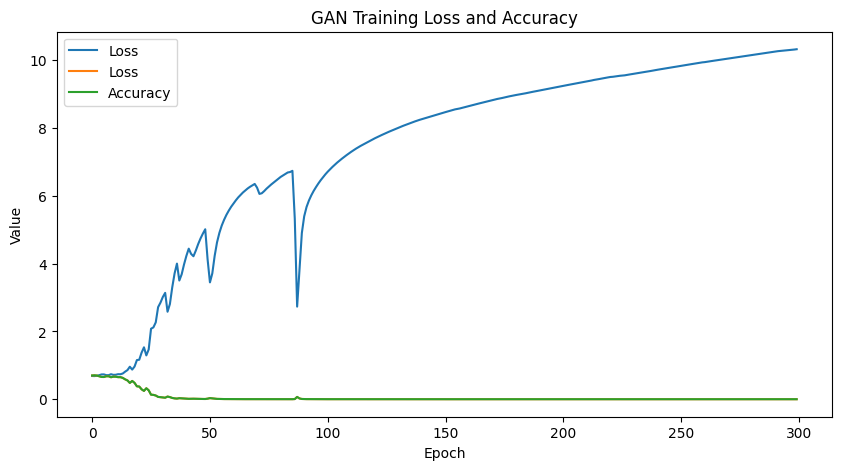

In [ ]:
# Plot loss and accuracy graph
def plot_loss_accuracy(losses, accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.title('GAN Training Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_loss_accuracy(losses, accuracies)

In [ ]:
import tensorflow as tf

# Load the generator model
generator = tf.keras.models.load_model('/content/rupees_Model.h5', compile=False)

# Compile the loaded model with appropriate metrics
generator.compile(loss=generator_loss, optimizer=generator_optimizer)

# Generate new samples
num_samples = 10  # Replace with the desired number of samples
noise = tf.random.normal([num_samples, 100])
generated_images = generator(noise, training=False)


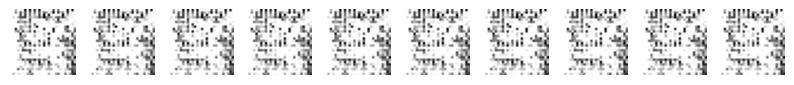

In [ ]:
generated_images = (generated_images + 1) / 2.0

# Plot the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
import imageio
import IPython.display as display
from PIL import Image


In [ ]:
# Rescale the generated images from [-1, 1] to [0, 255]
generated_images = ((generated_images + 1) * 127.5).astype('uint8')

# Create a list to store the generated images
image_list = []
for i in range(num_samples):
    image = Image.fromarray(generated_images[i, :, :, 0], mode='L')
    # Resize the image to a larger size
    resized_image = image.resize((400, 400), Image.NEAREST)
    image_list.append(resized_image)

# Save the list of resized images as a GIF
imageio.mimsave('generated_images1.gif', image_list, duration=0.5)

# Display the enlarged GIF in the notebook
# display.Image('generated_images.gif')

AttributeError: ignored

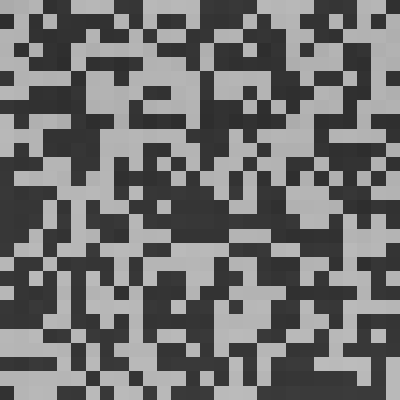

In [ ]:
display.Image('/content/generated_images1.gif')